In [2]:
import piplite
await piplite.install('cabinetry')

In [27]:
from matplotlib import pyplot as plt
import numpy
import random
import math
import pyhf
import cabinetry

# Practical Fits

### Peter Onyisi

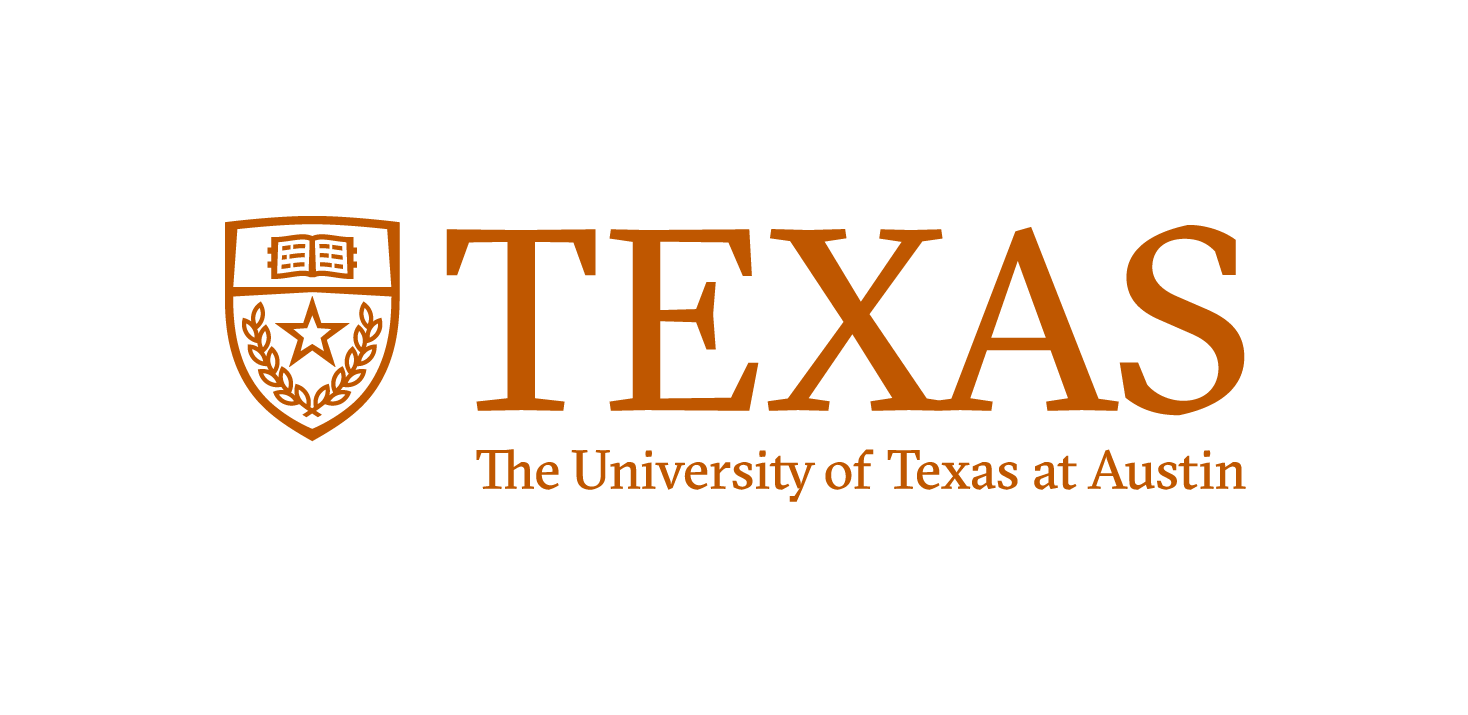

## Introduction

The goal today will be to lead you through some practical scenarios.

We will mostly use the `pyhf` and `cabinetry` packages to handle the underlying numerical work. There is an equivalent C++ ROOT ecosystem (`RooFit`/`RooStats`) should you want.

> ⚠️ Everything we discuss today will be for so-called _binned_ fits. For unbinned fits, the relevant Python packages are `zfit` and `hepstats`. Unfortunately these are out of scope for today.

## Counting experiments

A "counting experiment" is one of the simplest things we can do: we predict a (real number) yield $N$ and compare it to the observed (integer) number of events $Y$, where the PDF is that of a Poisson distribution:
$$ \ln\mathcal{L} = Y \ln N - N - \ln Y! $$
The total expected yield $N$ is typically composed of a background expectation $N_b$ and a signal yield $N_s$ (i.e., $N = N_b + N_s$). We usually know $N_b$ from simulation, where it will depend on some nuisance parameters from systematics: theoretical uncertainties, detector modeling, luminosity, and so on. The value of $N_s$ may or may not have an expectation (if we are looking for a Standard Model Higgs signal, we probably know the expectation for $N_s$ quite well; if doing a speculative search for beyond the Standard Model physics, we probably don't know it at all). If there is a reference value $N_{s0}$, it is very standard to write $N_s = \mu N_{s0}$ and use $\mu$ as the "parameter of interest" instead of $N_s$ itself. So in general we will have
$$ N = N_b(\theta_b) + \mu N_s(\theta_s) $$
with various nuisance parameters $\theta_b$ and $\theta_s$, and prior constraints on the nuisance parameters added to the likelihood:
$$ \ln \mathcal{L} = Y\ln (N_b + \mu N_s) - (N_b + \mu N_s) - \ln Y! + \sum_j \ln P(\theta_j) $$

In general one is either interested in estimating $N_s$ (measurements) or setting an upper limit on it (searches). For a one-bin counting experiment, the value of $\mu$ (or $N_s$) is unconstrained and so the maximum-likelihood estimator for $N_s$ is just $(Y - \hat N_b)$ where $\hat N_b$ is the expected yield at the highest-likelihood value of the nuisance parameters. The impact of the NPs will be seen in the uncertainties on $N_s$ (equivalently, the upper limit on it).

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMe

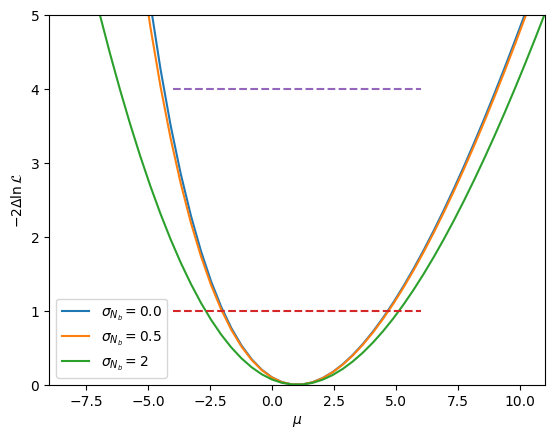

2*Sqrt(bkg) = 3.16
2*Sqrt(bkg) = 6.32
Bkg uncertainty 0.00: mu uncertainty -2.99 +3.66, quadrature uncertainty 3.16
Bkg uncertainty 0.50: mu uncertainty -3.04 +3.69, quadrature uncertainty 3.20
Bkg uncertainty 2.00: mu uncertainty -3.69 +4.11, quadrature uncertainty 3.74
Bkg uncertainty 0.00: 95% CLs limit 7.54
Bkg uncertainty 0.50: 95% CLs limit 7.59
Bkg uncertainty 2.00: 95% CLs limit 8.30


In [74]:
errorbars = []
for bkg_uncert in (0., 0.5, 2):
    model = pyhf.simplemodels.uncorrelated_background(
        signal=[1], bkg=[10], bkg_uncertainty=[bkg_uncert]
    )
    starting_bounds = model.config.suggested_bounds()
    starting_bounds[model.config.poi_index] = (-50, 50)
    # for frequentist reasons we make up an "auxiliary measurement" for the systematic constraint
    data = [11] + model.config.auxdata
    result = cabinetry.fit.fit(model, data, minos='mu', par_bounds=starting_bounds)
    errorbars.append((bkg_uncert, result.minos_uncertainty['mu']))
    result = cabinetry.fit.scan(model, data, par_name='mu', par_range=[-9, 11],
                                par_bounds=starting_bounds, n_steps=50)
    # print(result)
    plt.plot(result.parameter_values, result.delta_nlls, label=r'$\sigma_{N_b}=' + f'{bkg_uncert}$')
plt.ylim(0,5)
plt.xlim(-9,11)
plt.plot([-4, 6], [1, 1], '--')
plt.plot([-4, 6], [4, 4], '--')
plt.ylabel(r'$-2\Delta \ln \mathcal{L}$')
plt.xlabel(r'$\mu$')
plt.legend()

limits = []
for bkg_uncert in (0,.5,2):
    model = pyhf.simplemodels.uncorrelated_background(
        signal=[1], bkg=[10], bkg_uncertainty=[bkg_uncert]
    )
    starting_bounds = model.config.suggested_bounds()
    starting_bounds[model.config.poi_index] = (0, 50)
    # for frequentist reasons we make up an "auxiliary measurement" for the systematic constraint
    data = [10] + model.config.auxdata
    # print(cabinetry.fit.fit(model, data))
    result = cabinetry.fit.limit(model, data, bracket=[1, 20], par_bounds=starting_bounds)
    limits.append((bkg_uncert, result.observed_limit))
plt.show()
print(f'2*Sqrt(bkg) = {10**.5:.2f}')
print(f'2*Sqrt(bkg) = {2*10**.5:.2f}')
for item in errorbars:
    print(f'Bkg uncertainty {item[0]:.2f}: mu uncertainty {item[1][0]:.2f} +{item[1][1]:.2f}, quadrature uncertainty {(item[0]**2+10)**.5:.2f}')
for item in limits:
    print(f'Bkg uncertainty {item[0]:.2f}: 95% CLs limit {item[1]:.2f}')


For large enough $N_b$ (> 10 or so) one can reasonably approximate the Poisson probability with a Gaussian of standard deviation $\sqrt{N_b}$. In that case, we can expect that the uncertainty on $N_s$ for a no-signal hypothesis will be at least $\sqrt{N_b}$ (equality if there is no signal), and the 95% CL upper limit on $N_s$ will be roughly $2\sqrt{N_b}$ (the CLs limit will be a bit worse).



## Fitting histograms

So far we showed a lot of examples of _unbinned_ maximum likelihood: when we have a known PDF that describes the specific observables, and we measure event by event. This is sometimes plausible (we do this a lot in $B$-physics, for example, where we know (e.g.) that particle lifetime is described by an exponential). Far more commonly, though, we don't have analytic expressions for the PDF, but have rather simulated the distributions via Monte Carlo. In those cases the normal procedure is to approximate the PDF with histograms.

When you have several different variables, you can construct a multidimensional histogram to build a PDF for all the observables. However this rapidly hits the _curse of dimensionality_: the total number of bins goes as $M^N$, where $M$ is the number of bins in each dimension and $N$ is the number of dimensions, and so the number of events required to reasonably populate the bins increases exponentially with $N$. One can come up with adaptive binning mechanisms (basically, merging bins with small numbers of events) but this are complicated and hard to generalize. This is one of the big motivations for moving to "multivariate analysis techniques" (these days, we would say "machine learning" or "AI"): these attempt to construct a one-dimensional function (or, in any case, a low-dimensional one) that allows us to take multiple dimensions of data and project the maximum information to a 1-dimensional histogram. In principle, if we know the true PDF simultaneously in all observables, then there's nothing to be gained from ML techniques; the main motivation is effectively to _discover_ the structure embedded in some high-dimensional space which is too difficult for us to figure out on our own. In any case, these are not going to have any sort of physics-motivated shape or analytic PDF.

So we want to use a PDF based on a histogram. In principle we could do an unbinned fit with the histogram used as a PDF; in practice it is simpler (and equivalent) to treat each bin as a counting experiment where we compare the predicted yield from the simulation histogram with the number of events observed in that bin in data. We then combine the likelihoods for each bin to get the binned likelihood. The structure of the histogram itself is irrelevant (each bin is its own counting experiment) so multi-dimensional histograms or multiple bins can be unrolled into a single one-dimensional histogram.

If you have multiple bins, the fit can hopefully learn from different fit components and nuisance parameters having different shapes across the bins. If you understand the shape but not necessarily the normalization of a background, having a background-rich bin can help a lot.

In [102]:
# Construct to fits for a background with a large a priori normalization error
# one with a control bin, one without


model = pyhf.simplemodels.correlated_background(
    signal=[10], bkg=[100], bkg_up=[130], bkg_down=[70]
)
starting_bounds = model.config.suggested_bounds()
starting_bounds[model.config.poi_index] = (-50, 50)
# for frequentist reasons we make up an "auxiliary measurement" for the systematic constraint
data = [110] + model.config.auxdata
result_nocr = cabinetry.fit.fit(model, data, minos='mu', par_bounds=starting_bounds)
errors_nocr = result_nocr.minos_uncertainty['mu']
# result = cabinetry.fit.scan(model, data, par_name='mu', par_range=[-9, 11],
#                             par_bounds=starting_bounds, n_steps=50)
# # print(result)
# plt.plot(result.parameter_values, result.delta_nlls, label=r'$\sigma_{N_b}=' + f'{bkg_uncert}$')
# plt.ylim(0,5)
# plt.xlim(-9,11)
# plt.plot([-4, 6], [1, 1], '--')
# plt.plot([-4, 6], [4, 4], '--')
# plt.ylabel(r'$-2\Delta \ln \mathcal{L}$')
# plt.xlabel(r'$\mu$')
# plt.legend()

model_cr = pyhf.simplemodels.correlated_background(
    signal=[10,.001], bkg=[100,200], bkg_up=[130,260], bkg_down=[70,140]
)
starting_bounds = model_cr.config.suggested_bounds()
starting_bounds[model_cr.config.poi_index] = (-50, 50)
# for frequentist reasons we make up an "auxiliary measurement" for the systematic constraint
data = [110,200.001] + model_cr.config.auxdata
result_cr = cabinetry.fit.fit(model_cr, data, minos='mu', par_bounds=starting_bounds)
errors_cr = result_cr.minos_uncertainty['mu']
print(f'Uncertainties with no control bin: {errors_nocr[0]:.2f} +{errors_nocr[1]:.2f}')
print(f'Uncertainties with a control bin: {errors_cr[0]:.2f} +{errors_cr[1]:.2f}')

W VariableMetricBuilder No improvement in line search
Uncertainties with no control bin: -3.17 +3.18
Uncertainties with a control bin: -1.24 +1.27


There is a correlation between the signal strength parameter $\mu$ and the parameter $\alpha$ that measures how far the background normalization is from its nominal value. Let's look at it for the two fits:

In [106]:
print('No control bin:')
print(result_nocr.labels)
print(result_nocr.corr_mat)
print(result_nocr.uncertainty)
print('With control bin:')
print(result_cr.labels)
print(result_cr.corr_mat)
print(result_cr.uncertainty)

No control bin:
['correlated_bkg_uncertainty', 'mu']
[[ 1.        -0.9439389]
 [-0.9439389  1.       ]]
[0.99303843 3.17489034]
With control bin:
['correlated_bkg_uncertainty', 'mu']
[[ 1.         -0.54867469]
 [-0.54867469  1.        ]]
[0.22934175 1.25435241]


(the parameter "correlated_bkg_uncertainty" is what we'll call $\alpha$ here; at $-1$ it means the background has assumed the "bkg_down" value, and at $+1$ it means the background has assumed the "bkg_up" value.)

Without the control bin, there is quite a large (negative) correlation between $\alpha$ and $\mu$, because an upward shift in $\alpha$ (increasing the background) can be exactly compensated in the core part of the likelihood by a downward shift in $\mu$. The degeneracy is broken by the constraint terms; otherwise there would be no way of distinguishing a background error from a signal, and the correlation would be $-1$. When we add the control bin, there is now additional information to aid in the constraint, and the correlation decreases significantly. (Note that this control region method can never improve the uncertainties due to _statistical_ fluctuations of the background; it can only reduce systematics.)

There are tools to visualize these:

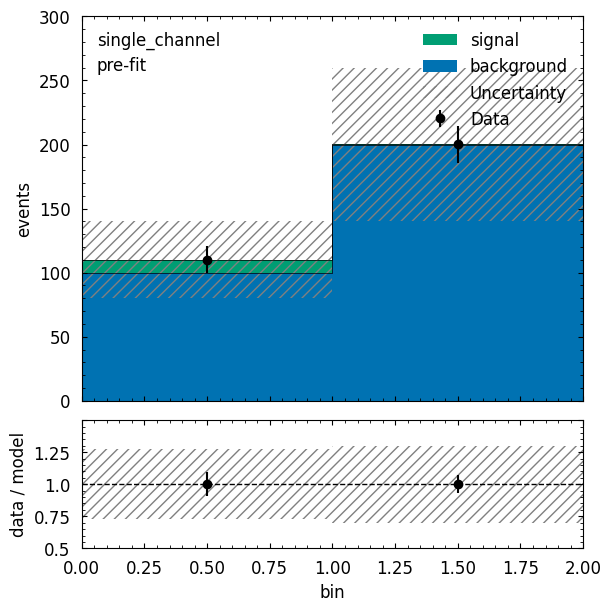

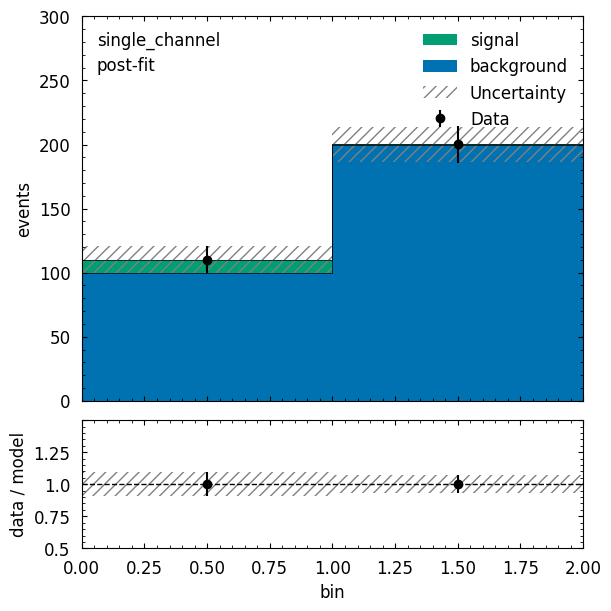

In [228]:
prefit = cabinetry.model_utils.prediction(model_cr)
postfit = cabinetry.model_utils.prediction(model_cr, fit_results=result_cr)
cabinetry.visualize.data_mc(prefit, [110,200.001])
cabinetry.visualize.data_mc(postfit, [110,200.001])
plt.show()

Here the code uses the uncertainties on the parameters after the fit, and the correlation matrix, to determine the uncertainty in each bin. The post-fit plot shows the systematic uncertainty is significantly reduced by using the information available in the fit.

As a general rule, if pre-fit the systematics are large compared to statistical uncertainty, the post-fit systematics bands will be rougly the size of the statistical uncertainties. The individual systematics may still be large but anticorrelated.

Let's look at what happens when we have multiple systematics. We will have to move to the full model construction interface available via `pyhf`.

In [215]:
spec = {
    "channels": [
        { "name": "channel",
          "samples": [
            { "name": "signal",
              "data": [25.0, 10.0],
              "modifiers": [ { "name": "mu", "type": "normfactor", "data": None} ]
            },
            { "name": "background",
              "data": [50.0, 60.0],
              "modifiers": [  {"name": "bkgnorm", "type": "normsys", 
                               "data": { "hi": 1.2, "lo": 0.8 } },
                             {"name": "shape", "type": "histosys", 
                              "data": { "hi_data": [55.0, 72.0],
                                        "lo_data": [45.0, 48.0] } },           
                              ]
            }
          ]
        }
    ],
}

model = pyhf.Model(spec)
starting_bounds = model.config.suggested_bounds()
starting_bounds[model.config.poi_index] = (-50, 50)
# for frequentist reasons we make up an "auxiliary measurement" for the systematic constraint
data = [75,70] + model.config.auxdata
result = cabinetry.fit.fit(model, data, minos='mu', par_bounds=starting_bounds)
# ranking = cabinetry.fit.ranking(model, data, fit_results=result)
ranking = cabinetry.fit.ranking(model, data)
errors = result.minos_uncertainty['mu']
print(f'Uncertainties: {errors[0]:.2f} +{errors[1]:.2f}')

Uncertainties: -0.49 +0.52


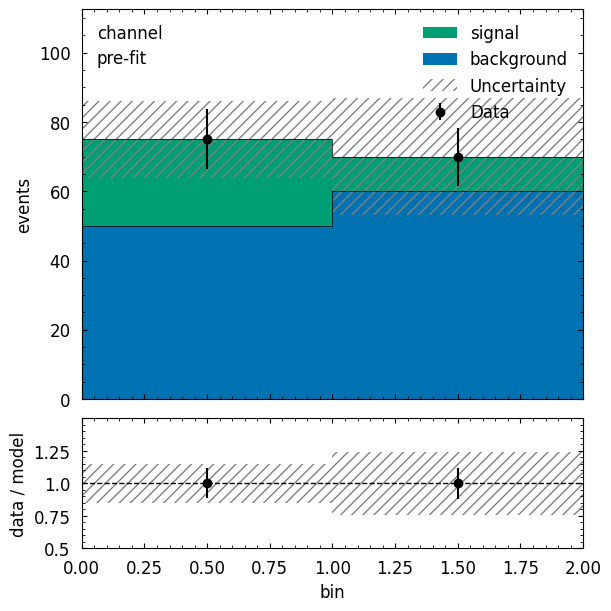

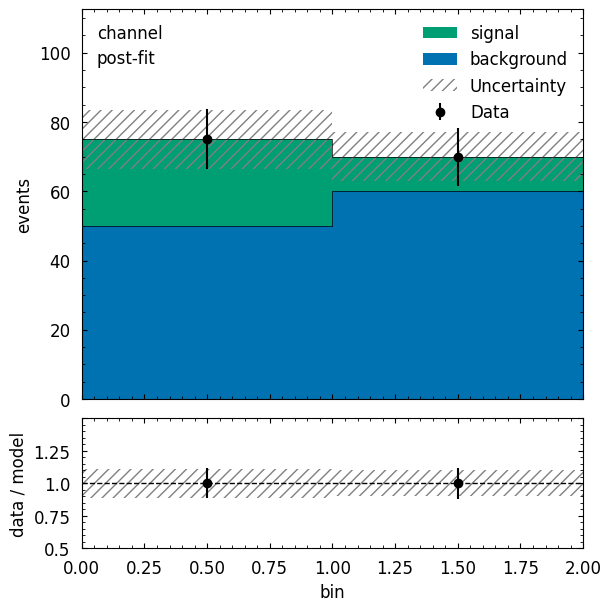

In [216]:
prefit = cabinetry.model_utils.prediction(model)
postfit = cabinetry.model_utils.prediction(model, fit_results=result)
cabinetry.visualize.data_mc(prefit, [75,70])
cabinetry.visualize.data_mc(postfit, [75,70])
plt.show()


Each extra bin in the fit adds "one piece" of information - it can potentially break one degeneracy. This means that if you have more bins than you have parameters in the fit, you could potentially constrain all parameters. 

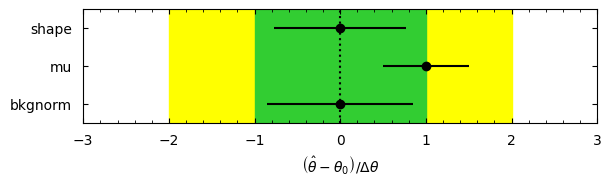

In [217]:
cabinetry.visualize.pulls(result, close_figure=False)
plt.show()

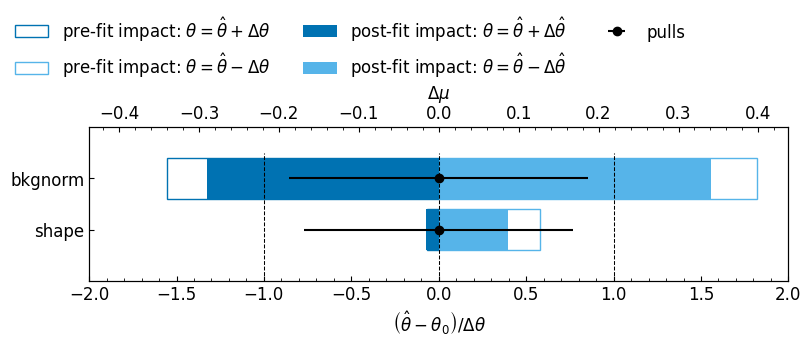

In [218]:
ranking_plot = cabinetry.visualize.ranking(ranking, close_figure=False)
plt.show()

FitResults(bestfit=array([7.04938900e-09, 1.00000001e+00, 2.07738073e-08]), uncertainty=array([0.76811916, 0.50574742, 0.85453433]), labels=['shape', 'mu', 'bkgnorm'], corr_mat=array([[ 1.        , -0.09323197, -0.4923864 ],
       [-0.09323197,  1.        , -0.62311495],
       [-0.4923864 , -0.62311495,  1.        ]]), best_twice_nll=15.922094766462033, goodness_of_fit=-1, minos_uncertainty={'mu': (-0.49227030798412597, 0.5191513086138255)})
FitResults(bestfit=array([-2.        ,  1.3814805 ,  0.99806652]), uncertainty=array([0.        , 0.54152095, 0.93512396]), labels=['shape', 'mu', 'bkgnorm'], corr_mat=array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        , -0.78912371],
       [ 0.        , -0.78912371,  1.        ]]), best_twice_nll=24.387711026433408, goodness_of_fit=-1, minos_uncertainty={'mu': (-0.5507462654219507, 0.5354308850168102)})
FitResults(bestfit=array([ 2.        ,  0.96979498, -0.99290177]), uncertainty=array([0.        , 0.47432595, 0.63

[{'figure': <Figure size 600x600 with 2 Axes>, 'region': 'channel'}]

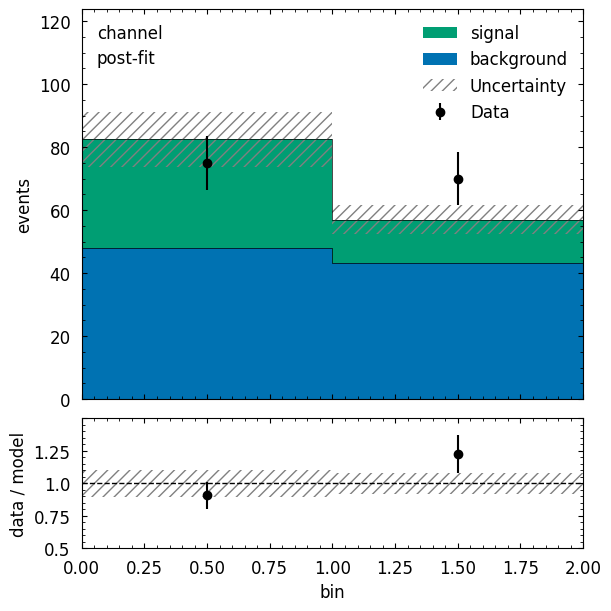

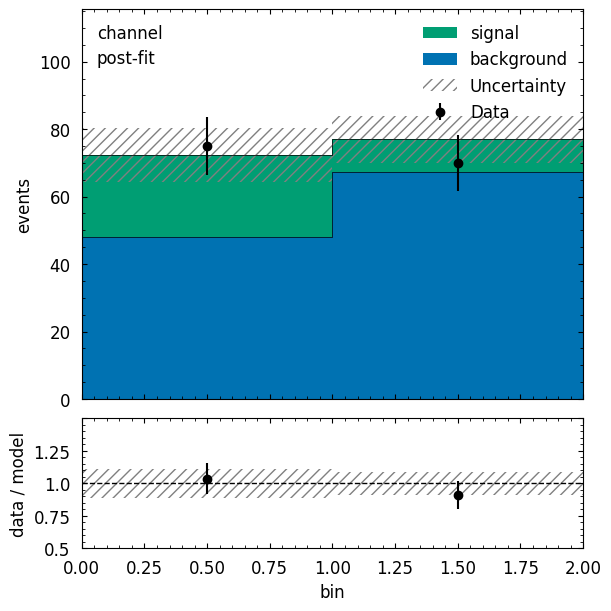

In [223]:
print(cabinetry.fit.fit(model, data, minos='mu', par_bounds=starting_bounds,
                        init_pars=[0, 1, 0], fix_pars=[False, False, False]))
rlo = cabinetry.fit.fit(model, data, minos='mu', par_bounds=starting_bounds,
                        init_pars=[-2, 1, 0], fix_pars=[True, False, False])
rhi = cabinetry.fit.fit(model, data, minos='mu', par_bounds=starting_bounds,
                        init_pars=[2, 1, 0], fix_pars=[True, False, False])
postfitlo = cabinetry.model_utils.prediction(model, fit_results=rlo)
print(rlo)
cabinetry.visualize.data_mc(postfitlo, [75,70])
postfithi = cabinetry.model_utils.prediction(model, fit_results=rhi)
print(rhi)
cabinetry.visualize.data_mc(postfithi, [75,70])

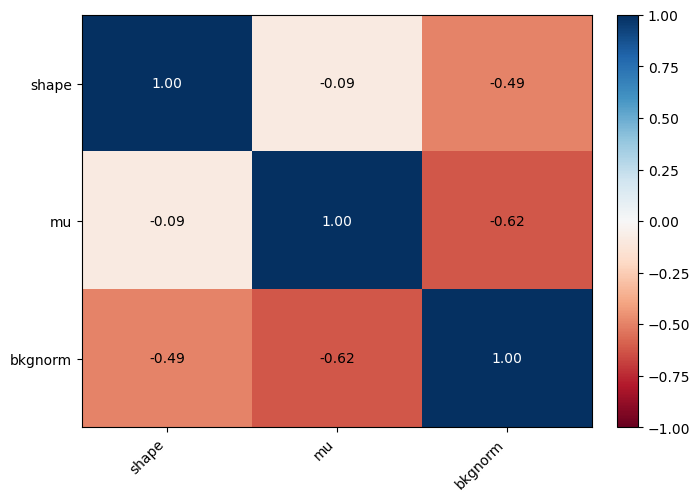

In [170]:
correlation_plot = cabinetry.visualize.correlation_matrix(result, close_figure=False)
plt.show()

What if the data aren't "perfect" ?

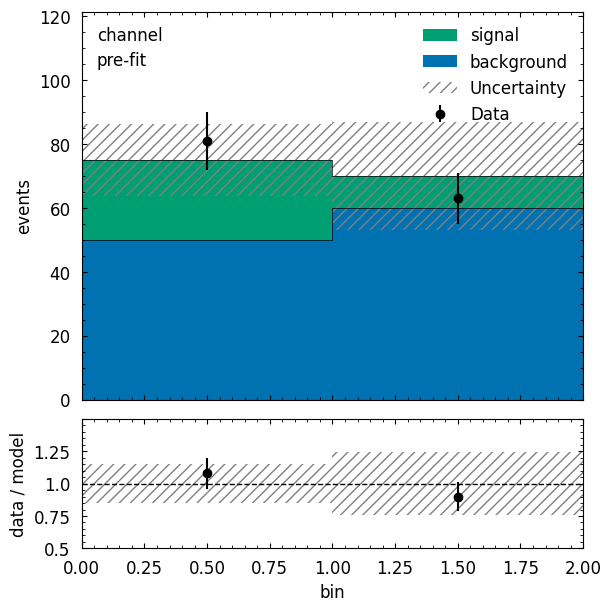

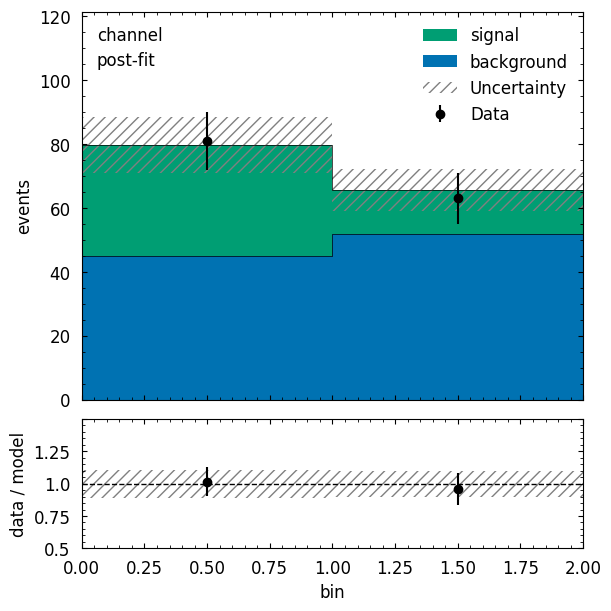

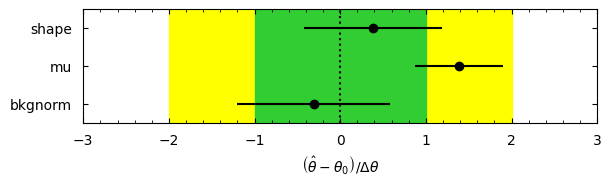

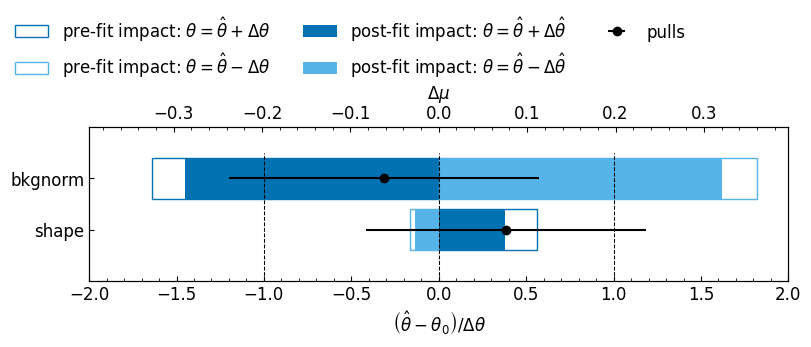

In [195]:
data = [81,63] + model.config.auxdata
result = cabinetry.fit.fit(model, data, minos='mu', par_bounds=starting_bounds)
ranking = cabinetry.fit.ranking(model, data, fit_results=result)
prefit = cabinetry.model_utils.prediction(model)
postfit = cabinetry.model_utils.prediction(model, fit_results=result)
cabinetry.visualize.data_mc(prefit, [81,63])
cabinetry.visualize.data_mc(postfit, [81,63])
plt.show()
cabinetry.visualize.pulls(result, close_figure=False)
plt.show()
cabinetry.visualize.ranking(ranking, close_figure=False)
plt.show()